<a href="https://colab.research.google.com/github/drdips/carcinoma_classification/blob/master/transferlearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning Strategies

In [1]:
import os
os.environ['KAGGLE_USERNAME'] = "" # username from the json file
os.environ['KAGGLE_KEY'] = "" # key from the json file

In [2]:
!kaggle datasets download -d paultimothymooney/breast-histopathology-images

100% 3.10G/3.10G [00:39<00:00, 147MB/s]
100% 3.10G/3.10G [00:39<00:00, 83.7MB/s]


In [3]:
!unzip -q breast-histopathology-images.zip 

In [1]:
import pandas as pd
import numpy as np
import os
from glob import glob
import itertools
import fnmatch
import random
import matplotlib.pylab as plt
import seaborn as sns
import cv2
# from scipy.misc import imresize, imread
import sklearn
from sklearn import model_selection
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, learning_curve, GridSearchCV
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import keras
from keras import backend as K
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, model_from_json
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
#let's take a look at if we're in the right folder
imagePatches = glob('/content/IDC_regular_ps50_idx5/**/*.png', recursive=True)
for filename in imagePatches[0:15]:
    print(filename)

/content/IDC_regular_ps50_idx5/10295/1/10295_idx5_x1501_y1901_class1.png
/content/IDC_regular_ps50_idx5/10295/1/10295_idx5_x1451_y1451_class1.png
/content/IDC_regular_ps50_idx5/10295/1/10295_idx5_x1151_y1601_class1.png
/content/IDC_regular_ps50_idx5/10295/1/10295_idx5_x1301_y1551_class1.png
/content/IDC_regular_ps50_idx5/10295/1/10295_idx5_x1651_y1351_class1.png
/content/IDC_regular_ps50_idx5/10295/1/10295_idx5_x1201_y1901_class1.png
/content/IDC_regular_ps50_idx5/10295/1/10295_idx5_x1351_y1951_class1.png
/content/IDC_regular_ps50_idx5/10295/1/10295_idx5_x1401_y1701_class1.png
/content/IDC_regular_ps50_idx5/10295/1/10295_idx5_x1201_y1851_class1.png
/content/IDC_regular_ps50_idx5/10295/1/10295_idx5_x1501_y1701_class1.png
/content/IDC_regular_ps50_idx5/10295/1/10295_idx5_x1551_y1801_class1.png
/content/IDC_regular_ps50_idx5/10295/1/10295_idx5_x1201_y1801_class1.png
/content/IDC_regular_ps50_idx5/10295/1/10295_idx5_x1401_y1651_class1.png
/content/IDC_regular_ps50_idx5/10295/1/10295_idx5_x

In [4]:
classZero = '*class0.png'
classOne = '*class1.png'
classZero = fnmatch.filter(imagePatches, classZero)
classOne = fnmatch.filter(imagePatches, classOne)
print("IDC(-)\n\n",classZero[0:5],'\n')
print("IDC(+)\n\n",classOne[0:5])

IDC(-)

 ['/content/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1251_y2051_class0.png', '/content/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1251_y1151_class0.png', '/content/IDC_regular_ps50_idx5/10295/0/10295_idx5_x551_y1051_class0.png', '/content/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1201_y1101_class0.png', '/content/IDC_regular_ps50_idx5/10295/0/10295_idx5_x951_y1401_class0.png'] 

IDC(+)

 ['/content/IDC_regular_ps50_idx5/10295/1/10295_idx5_x1501_y1901_class1.png', '/content/IDC_regular_ps50_idx5/10295/1/10295_idx5_x1451_y1451_class1.png', '/content/IDC_regular_ps50_idx5/10295/1/10295_idx5_x1151_y1601_class1.png', '/content/IDC_regular_ps50_idx5/10295/1/10295_idx5_x1301_y1551_class1.png', '/content/IDC_regular_ps50_idx5/10295/1/10295_idx5_x1651_y1351_class1.png']


## Pulling our data!

In [5]:
def proc_images(lowerIndex,upperIndex):
    """
    Returns two arrays: 
        x is an array of resized images
        y is an array of labels
    """ 
    x = []
    y = []
    patient = []
    WIDTH = 75
    HEIGHT = 75


    for img in imagePatches[lowerIndex:upperIndex]:
        full_size_image = cv2.imread(img)
        x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT)))
        patient.append(img)


        if img in classZero:
            y.append(0)
        elif img in classOne:
            y.append(1)
        else:
            return
    return x,y, patient

In [6]:
def only_ones(lowerIndex,upperIndex):
    """
    Returns two arrays: 
        x is an array of resized images
        y is an array of labels
    """ 
    x = []
    y = []
    patient = []
    WIDTH = 75
    HEIGHT = 75

    for img in imagePatches[lowerIndex:upperIndex]:

        if img in classOne:
            full_size_image = cv2.imread(img)
            x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT)))
            patient.append(img)
            y.append(1)
        elif img in classZero:
            continue
        else:
            return
    return x,y, patient

In [7]:
A,B, patient1 = proc_images(0,20000)

In [8]:
#we have a huge imbalance so let's pull some positives 
C,D, patient2 = only_ones(20001,50000)

In [9]:
X = np.concatenate([A, C], axis=0)
Y = np.concatenate([B, D], axis=0)
patient = np.concatenate([patient1, patient2], axis=0)

In [10]:
X_test, Y_test, patient = proc_images(50001,70000)

## Let's split our data!

In [11]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2)
# X_train, X_val, Y_train, Y_val = train_test_split(X_model, Y_model, test_size=0.2)

In [12]:
from keras.utils.np_utils import to_categorical
X_train=np.array(X_train)/255
y_trainHot = to_categorical(Y_train, num_classes = 2)

X_test=np.array(X_test)/255
y_testHot = to_categorical(Y_test, num_classes = 2)

X_val=np.array(X_val)/255
y_valHot = to_categorical(Y_val, num_classes = 2)

## Here comes Inception!

A google ai blog suggested inception being the best transfer model when it comes to healthcare image recognizition. So let's try it first!

In [13]:
from keras.applications import inception_v3
from keras.layers import Dense,GlobalAveragePooling2D
from sklearn.metrics import confusion_matrix, f1_score
from keras.models import Model

In [20]:
imagenet=inception_v3.InceptionV3(weights='imagenet',include_top=False, input_shape=(75,75,3))
imagenet_new=imagenet.output
new_model = Sequential()
new_model.add(imagenet)
new_model.add(GlobalAveragePooling2D())
new_model.add(Dense(1024,activation='relu'))
# new_model.add(Dense(1024,activation='relu')) #dense layer 2
# new_model.add(Dense(512,activation='relu')) #dense layer 3
new_model.add(Dense(2,activation='softmax')) #final layer with softmax activation

In [21]:
for layer in new_model.layers[:1]:
    layer.trainable=False

In [30]:
new_model.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])

# step_size_train=train_generator.n//train_generator.batch_size
history = new_model.fit(X_train,
          Y_train,
          epochs=10,
          batch_size=50,
          validation_data=(X_val, Y_val))

Epoch 1/10
466/466 [==============================] - 13s 27ms/step - loss: 0.6932 - accuracy: 0.5005 - val_loss: 0.6932 - val_accuracy: 0.5250
Epoch 2/10
466/466 [==============================] - 11s 25ms/step - loss: 0.6931 - accuracy: 0.5018 - val_loss: 0.6931 - val_accuracy: 0.5664
Epoch 3/10
466/466 [==============================] - 11s 24ms/step - loss: 0.6931 - accuracy: 0.5024 - val_loss: 0.6931 - val_accuracy: 0.4709
Epoch 4/10
466/466 [==============================] - 11s 25ms/step - loss: 0.6931 - accuracy: 0.5048 - val_loss: 0.6931 - val_accuracy: 0.5135
Epoch 5/10
466/466 [==============================] - 11s 25ms/step - loss: 0.6931 - accuracy: 0.5028 - val_loss: 0.6931 - val_accuracy: 0.4946
Epoch 6/10
466/466 [==============================] - 11s 24ms/step - loss: 0.6931 - accuracy: 0.5042 - val_loss: 0.6931 - val_accuracy: 0.5319
Epoch 7/10
466/466 [==============================] - 11s 25ms/step - loss: 0.6931 - accuracy: 0.5032 - val_loss: 0.6931 - val_accuracy:

In [23]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

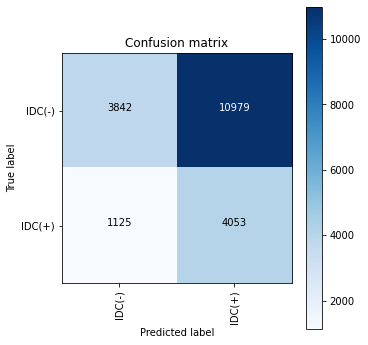

In [31]:
y_pred = new_model.predict(X_test)
Y_pred_classes = np.argmax(y_pred,axis=1) 
Y_true = np.argmax(y_testHot,axis=1)
dict_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values())) 
plt.show()

In [32]:
from sklearn.metrics import classification_report
print(classification_report(Y_true, Y_pred_classes, target_names = ['IDC (-)','IDC (+)']))

              precision    recall  f1-score   support

     IDC (-)       0.77      0.26      0.39     14821
     IDC (+)       0.27      0.78      0.40      5178

    accuracy                           0.39     19999
   macro avg       0.52      0.52      0.39     19999
weighted avg       0.64      0.39      0.39     19999



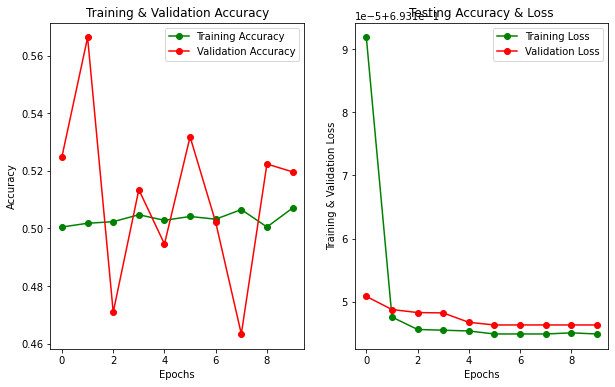

In [34]:
epochs = [i for i in range(10)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(10,6)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

Not as well as I thought, the model definitely overfit the positive cases in this case. Time to move on to other transfer learning models